# Project 2: Digit Classification Naive Bayes

**Solution**

# Intro
---
In this project, you'll continue working on your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b>


## Grading
---
 - Make sure to answer every part in every question.
 - There are 6 questions, each equally weighted and an additional bonus question.
 - The extra credit question will be graded based on your attempts at feature engineering and resulting improved accuracy.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean, well commented,
  -  if the functions or answers are too long.

## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

## Additional Reading and notes
---
If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [14]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'0.24.1'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', as_frame=False, return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_). 
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

In [12]:
def Q1():
### STUDENT START ###

    def get_adjacent(arr, row, col):
        val, right, left = arr[row][col], arr[row][col + 1], arr[row][col-1]
        top, bottom, top_left  = arr[row - 1][col], arr[row + 1][col], arr[row - 1][col - 1] 
        top_right, bottom_left, bottom_right = arr[row - 1][col + 1], arr[row + 1][col - 1], arr[row + 1][col + 1]
        return np.array([top_left, top, top_right, 
                         left, val, right, 
                         bottom_left, bottom, bottom_right]).reshape((3, 3))

    def smooth(data):
        #Smoothing out the pixels for each image in MINI_TRAIN_DATA
        kernel = np.array([[.1, .1, .1], [.1, .2, .1], [.1, .1, .1]])

        smoothed_data = np.zeros((data.shape))

        count = 0
        for image in data:
            image_matrix, rows, cols = image.reshape((28, 28)), 28, 28
            output = np.zeros((rows, cols))  
            for row in np.arange(rows - 1):
                for col in np.arange(cols - 1):
                    output[row, col] = np.sum(get_adjacent(image_matrix, row, col) * kernel)

            smoothed_data[count] = output.reshape((784,))
            count += 1

        return smoothed_data
    
    #Filtering out data for future use in KNN model
    smooth_mini_train_data = smooth(mini_train_data)
    smooth_dev_data = smooth(dev_data)
    
    def create_and_evaluate_KNN(training_set, dev_set, num):
        #Helper function to create and evaluate a KNN model
        knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
        knn.fit(training_set, mini_train_labels)
        accuracy = knn.score(dev_set, dev_labels)
        print(f"Model {num} Accuracy: {accuracy}")
        
    
    ### Creating four KNN models ### 
    # Model 1: Do not use the filter
    create_and_evaluate_KNN(mini_train_data, dev_data, 1)
    
    #Model 2: Filter training data, not the dev data
    create_and_evaluate_KNN(smooth_mini_train_data, dev_data, 2)
    
    #Model 3: Filter dev data, not the training data
    create_and_evaluate_KNN(mini_train_data, smooth_dev_data, 3)
    
    #Model 4: Filter both training and dev data
    create_and_evaluate_KNN(smooth_mini_train_data, smooth_dev_data, 4)
    
### STUDENT END ###

Q1()

Model 1 Accuracy: 0.884
Model 2 Accuracy: 0.906
Model 3 Accuracy: 0.868
Model 4 Accuracy: 0.901


### Question 2: Modeling your data and experimenting with different Naive Bayes models. 
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



In [5]:
# Solution with binarization by explicit binarize function

def Q2():
### STUDENT START ###

    ##### Model 1: Binomial Naive Bayes #####
    #Binarizing data for the model
    binarized_mini_train_data = np.where(mini_train_data > 0, 1, 0)
    binarized_dev_data = np.where(dev_data > 0, 1, 0)
    
    #Training and evaluating the model 
    BNB = BernoulliNB()
    BNB.fit(binarized_mini_train_data, mini_train_labels)
    accuracy = BNB.score(binarized_dev_data, dev_labels)
    print(f"Binomial NB accuracy: {accuracy}")
    
    
    ##### Model 2: Multinomial Naive Bayes #####
    def trinarize(arr):
        #Helper function for trinarization 
        output = np.zeros(arr.shape)
        output[(arr < 0.1)] = 0
        output[(arr >= 0.1)] = 1
        output[(arr >= 0.9)] = 2
        return output
    
    trinarized_mini_train_data = trinarize(mini_train_data)
    trinarized_dev_data = trinarize(dev_data)
    
    #Training and evaluating the model
    MNB = MultinomialNB()
    MNB.fit(trinarized_mini_train_data, mini_train_labels)
    accuracy = MNB.score(trinarized_dev_data, dev_labels)
    print(f"Multinomial NB accuracy: {accuracy}")
    
### STUDENT END ###

Q2()

Binomial NB accuracy: 0.809
Multinomial NB accuracy: 0.807


ANSWER: The multinomial NB classifier **did not** improve accuracy. This is because introducing a third class does not really help with the overall classification results, and in fact it may be the case that doing so introduces more noise to the data such that the model performs worse.

### Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



In [6]:
def Q3(alphas):
### STUDENT START ###
    nb = GridSearchCV(estimator=BernoulliNB(binarize=0), param_grid=alphas,
                      cv = 5, scoring='accuracy')
    
    nb.fit(mini_train_data, mini_train_labels)
    
    mean_accuracies = nb.cv_results_['mean_test_score']
    
    for alpha, accuracy in zip(list(alphas['alpha']), mean_accuracies):
        print(f"Average accuracy for alpha = {alpha}: {accuracy}")
    
        
### STUDENT END ###

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas)


Average accuracy for alpha = 1e-10: 0.8139999999999998
Average accuracy for alpha = 0.0001: 0.819
Average accuracy for alpha = 0.001: 0.825
Average accuracy for alpha = 0.01: 0.8219999999999998
Average accuracy for alpha = 0.1: 0.818
Average accuracy for alpha = 0.5: 0.8130000000000001
Average accuracy for alpha = 1.0: 0.8089999999999999
Average accuracy for alpha = 2.0: 0.8049999999999999
Average accuracy for alpha = 10.0: 0.783


ANSWER: When $\alpha = 1.0^{-10}$ (closest value to 0), the accuracy is shown to be around $0.814$. This accuracy slowly increases as $\alpha$ increases, and reaches its maximum point at $\alpha = 0.001$ where $accuracy \approx 82.5 \%$, as such, this is the *best value for $\alpha$.* I did not expect this to be the case, I believed that $\alpha$'s closer to 0 will produce better accuracies. 

### Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

In [7]:
def Q4():

### STUDENT END ###
    GNB = GaussianNB()
    GNB.fit(mini_train_data, mini_train_labels)
    accuracy = GNB.score(dev_data, dev_labels)
    print(f"Gaussian NB accuracy: {accuracy}")
    
    smoothed_GNB = GaussianNB(var_smoothing=0.05)
    smoothed_GNB.fit(mini_train_data, mini_train_labels)
    accuracy = smoothed_GNB.score(dev_data, dev_labels)
    print(f"Smoothed Gaussian NB accuracy: {accuracy} ")
    
    

### STUDENT END ###

Q4()

Gaussian NB accuracy: 0.593
Smoothed Gaussian NB accuracy: 0.816 


ANSWER: The default Gaussian NB model's accuracy is $\approx 59.3\%$. Upon researching the `var_smoothing` argument, I believe that the default value assigned makes it so that the model is less generalizable as it assumes a very low variance in the underlying distribution. By increasing this value to be somewhere closer to 0, we are performing smoothing akin to Laplace smoothing for the Bernoulli and Multinomial NB. Increasing `var_smoothing` thus tells our model that the underlying distribution has a higher variance than the default model, this higher generalizability is reflected by the higher accuracy on the dev set, which reaches a maximum of $\approx 82\%$ when `var_smoothing`$\in[0.05- 0.09]$

### Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



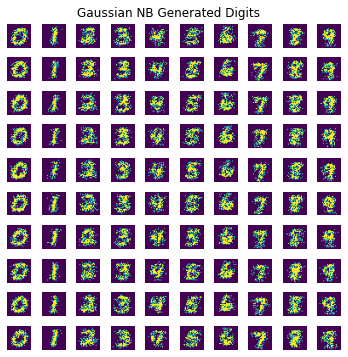

In [13]:
def Q5(num_examples):
### STUDENT START ###

    #Training Gaussian NB 
    binarized_mini_train_data = np.where(mini_train_data > 0, 1, 0)
    BNB = BernoulliNB(alpha=0.001)
    BNB.fit(binarized_mini_train_data, mini_train_labels)
    
    posterior_probabilities = BNB.feature_log_prob_
    
    def generate(probabilities):
        random_numbers = np.random.rand(784)
        pixels = np.zeros((784,))
        for i in range(784):
            if random_numbers[i] <= np.exp(probabilities[i]):
                pixels[i] = 1
        return pixels.reshape((28,28))
    
    
    counter = 1
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    counter = 1
    for i in range(10):
        for j in range(10):
            plt.rcParams["figure.figsize"] = (6, 6)
            fig.add_subplot(10, 10, counter, frameon=False)
            plt.imshow(generate(posterior_probabilities[j]))
            plt.xticks([])
            plt.yticks([])
            counter +=1
    fig.suptitle("Gaussian NB Generated Digits", y=0.92)


### STUDENT END ###

Q5(10)

ANSWER: One of the biggest differences between the original and generated images is that the generated images are binarized. The generated images also appear to contain more noise, but this makes sense given the random generation process. 

### Question 6: Model Calibraiton
---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9. 
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance: 
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket. 
    - So, for each prediction:
       - Find the bucket whose range includes the estimated posterior probability, 
       - and update "correct" and "total" counters accordingly. 
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.



In [9]:
def Q6(buckets, correct, total):
### STUDENT START ###
    #Train BernoulliNB model with optimal smoothing parameters
    binarize = lambda x: np.where(x > 0, 1, 0)
    BNB = BernoulliNB(alpha=0.001)
    BNB.fit(binarize(mini_train_data), mini_train_labels)

    posterior_probabilities = BNB.feature_log_prob_
    
    #Predict labels using dev data
    predicted_y = BNB.predict(binarize(dev_data))
    
    #Predict probabilities using test data
    predicted_log_probs = BNB.predict_log_proba(binarize(dev_data))
    
    binarized_dev_data = binarize(dev_data)
    for i in range(binarized_dev_data.shape[0]):
        pred_y = predicted_y[i]
        pred_log_prob = predicted_log_probs[i]
        actual_y = dev_labels[i]
        counter = 0 
        for bucket in buckets:
            if np.exp(pred_log_prob)[0] <= bucket:
                total[counter] += 1 
                if pred_y == actual_y:
                    correct[counter] += 1
            counter += 1
            
    accuracy = np.array(correct)/np.array(total)
    return accuracy

### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

Q6(buckets, correct, total)

array([0.81      , 0.81      , 0.80931264, 0.80773481, 0.80837004,
       0.80858086, 0.80858086, 0.80879121, 0.823     ])

ANSWER: I would say that this model is poorly calibrated given that there is no apparent correlation between the bucket's value and the model accuracy. In fact, accuracy decreases from 0.9 to 0.999. 

### Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image. 
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [10]:
def Q7():

### STUDENT START ###

### STUDENT END ###

Q7()

IndentationError: expected an indented block (<ipython-input-10-57d016c02e77>, line 7)